# Telco Churn Report
Sophia Stewart

November 29, 2021

---

### Executive Summary
The goal of this project is to identify factors that lead to customer churn at Telco and then make recommendations to reduce churn and increase customer retention. In this report, I will go through the steps that led me to my final recommendation and top-performing model.

In [1]:
# import modules needed to run report
import pandas as pd
import telco_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# to ignore any pink warnings
import warnings
warnings.filterwarnings("ignore")

To begin, I defined functions to acquire, clean, and split the telco data. To deal with the missing values I discovered in the total_charges column, I did some digging and found that the only rows missing a total_charges value have a tenure of 0. Since these are new customers who have not yet had the opportunity to churn, their data will probably not be useful in helping find a driver of churn. Therefore, I decided to drop the 11 rows with total_charges of ' '.

In [2]:
# get telco data and assign train, validate, test variables
train, validate, test = tf.wrangle_telco()

To get some context, I decided to look at the distributions of the variables related to my questions.

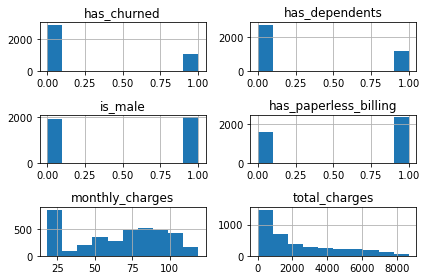

In [3]:
# view frequencies of variables relevant to questions
train[['has_churned', 'has_dependents', 'is_male', 'has_paperless_billing', 'monthly_charges', 'total_charges']].hist()
plt.tight_layout();

### Question 1: Do churned customers have higher monthly charges than customers who have not yet churned?

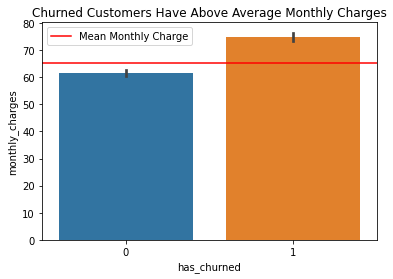

In [4]:
# visualize average monthly charges by whether a customer has churned
sns.barplot(data=train, x='has_churned', y='monthly_charges')
plt.axhline(train.monthly_charges.mean(), label='Mean Monthly Charge', color='r')
plt.title('Churned Customers Have Above Average Monthly Charges')
plt.legend();

### Answer 1:
Churned customers have, on average, a greater monthly service cost than customers who have not yet churned.

### Question 2: Is there a relationship between gender and rate of churn?

is_male,0,1
has_churned,,
0,1411,1474
1,510,530


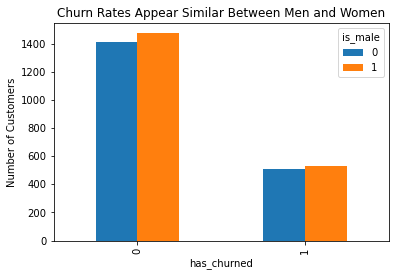

In [5]:
# create crosstab of gender/churn and visualize
pd.crosstab(train.has_churned, train.is_male).plot.bar()
plt.title('Churn Rates Appear Similar Between Men and Women')
plt.ylabel('Number of Customers')
pd.crosstab(train.has_churned, train.is_male)

In [6]:
# formulate null and alternative hypotheses
null_hypothesis = 'there is no relationship between gender and churn.'
alt_hypothesis = 'there is a relationship between gender and churn.'
# set alpha
alpha = 0.05
# run chi squared test
chi2, p, degf, expected = stats.chi2_contingency(pd.crosstab(train.has_churned, train.is_male))
# print results of stat test
print(f'chi^2: {chi2}, p: {p}\n')
if p > alpha:
    print(f'There is not sufficient evidence to reject our null hypothesis that {null_hypothesis}')
else:
    print(f'There is sufficient evidence to move forward with the alternative hypothesis that {alt_hypothesis}')

chi^2: 0.0012888143260670034, p: 0.9713620478259688

There is not sufficient evidence to reject our null hypothesis that there is no relationship between gender and churn.


### Answer 2:
Based on the visualization and statistical test, I conclude that there is not a significant relationship between gender and churn.

### Question 3: Is there a difference in rate of churn between customers with dependents and customers without dependents?

has_dependents,0,1
has_churned,,
0,1903,982
1,855,185


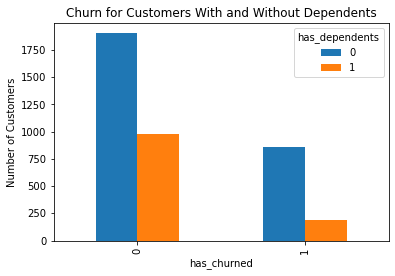

In [7]:
# create crosstab of dependent status/churn and visualize
pd.crosstab(train.has_churned, train.has_dependents).plot.bar()
plt.title('Churn for Customers With and Without Dependents')
plt.ylabel('Number of Customers')
pd.crosstab(train.has_churned, train.has_dependents)

In [8]:
# formulate null and alternative hypotheses
null_hypothesis = 'there is no relationship between having dependents and churning.'
alt_hypothesis = 'there is a relationship between having dependents and churning.'
# set alpha
alpha = 0.05
# run chi squared test
chi2, p, degf, expected = stats.chi2_contingency(pd.crosstab(train.has_churned, train.has_dependents))
# print results of stat test
print(f'chi^2: {chi2}, p: {p}\n')
if p > alpha:
    print(f'There is not sufficient evidence to reject our null hypothesis that {null_hypothesis}')
else:
    print(f'There is sufficient evidence to move forward with the alternative hypothesis that {alt_hypothesis}')

chi^2: 95.83834981493843, p: 1.2465742877698198e-22

There is sufficient evidence to move forward with the alternative hypothesis that there is a relationship between having dependents and churning.


### Answer 3:
Based on the visualization and chi squared test, I conclude that there is a relationship between churn and whether a customer has dependents.

### Question 4: Does whether or not a customer has paperless billing set up affect a customer's likelihood of churn?

has_paperless_billing,0,1
has_churned,,
0,1332,1553
1,248,792


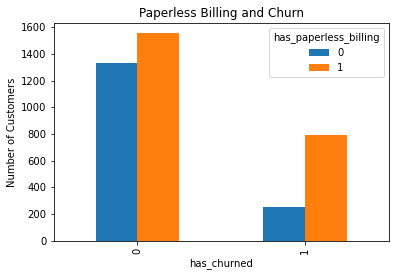

In [9]:
# create crosstab of paperless billing/churn and visualize
pd.crosstab(train.has_churned, train.has_paperless_billing).plot.bar()
plt.title('Paperless Billing and Churn')
plt.ylabel('Number of Customers')
pd.crosstab(train.has_churned, train.has_paperless_billing)

In [10]:
# formulate null and alternative hypotheses
null_hypothesis = 'there is no relationship between having paperless billing and churning.'
alt_hypothesis = 'there is a relationship between having paperless billing and churning.'
# set alpha
alpha = 0.05
# run chi squared test
chi2, p, degf, expected = stats.chi2_contingency(pd.crosstab(train.has_churned, train.has_paperless_billing))
# print results of stat test
print(f'chi^2: {chi2}, p: {p}\n')
if p > alpha:
    print(f'There is not sufficient evidence to reject our null hypothesis that {null_hypothesis}')
else:
    print(f'There is sufficient evidence to move forward with the alternative hypothesis that {alt_hypothesis}')

chi^2: 157.47157584323122, p: 4.0374327424237946e-36

There is sufficient evidence to move forward with the alternative hypothesis that there is a relationship between having paperless billing and churning.


### Answer 4:
Based on the visualization and the chi squared test, I conclude that having paperless billing and churning are not independent of one another.

## Exploratory Analysis Summary
From the visualizations and statistical tests I ran, I do not believe gender will be useful in predicting customer churn. It is clear that differences in monthly charges, dependents, and paperless billing are at least somewhat related to whether or not customers will churn.

## Modeling
For my models, I will be focusing on using the variables I found to be significant in my data exploration. These include 'has_dependents', 'has_paperless_billing', 'monthly_charges', and 'total_charges'. 

In [11]:
# create x and y versions of train, validate, and test samples
x_train = train[['has_dependents', 'has_paperless_billing', 'monthly_charges', 'total_charges']]
y_train = train.has_churned

x_validate = validate[['has_dependents', 'has_paperless_billing', 'monthly_charges', 'total_charges']]
y_validate = validate.has_churned

x_test = test[['has_dependents', 'has_paperless_billing', 'monthly_charges', 'total_charges']]
y_test = test.has_churned

### Choosing an Evaluation Metric
I decided to use accuracy as my evaluation metric for these models. Although there is some variation in the distribution of the classes, I believe accuracy will provide a clear picture of which model will best suit our business needs.

### Baseline Model
To create the baseline model, I will use the most common outcome of 'has_churned' as the prediction for all observations.

In [12]:
# view value counts
train.has_churned.value_counts()

0    2885
1    1040
Name: has_churned, dtype: int64

Since customers more often do not churn, '0' (not churned) will be the baseline prediction.

In [13]:
# compute baseline accuracy
(y_train == 0).mean()

0.7350318471337579

##### Baseline Accuracy is 73.5%.

### Model 1: Random Forest
For this model, I am setting the max depth to 10, the random state to 123, and minimum samples per leaf to 1.

In [14]:
# create random forest object
rf = RandomForestClassifier(min_samples_leaf=1, max_depth=10, random_state=123)
# fit object to train sample
rf.fit(x_train, y_train)
# make predictions
y_pred = rf.predict(x_train)
# compute and print accuracy
print(f'Model 1 Train Accuracy: {accuracy_score(y_train, y_pred):.2%}')

Model 1 Train Accuracy: 87.80%


### Model 2: KNN
For this model, I am using the default settings for the K-Nearest Neighbors classifier.

In [15]:
# create k-nearest neighbor object
knn = KNeighborsClassifier()
# fit object to train sample
knn.fit(x_train, y_train)
# make predictions
y_pred = knn.predict(x_train)
# compute and print accuracy
print(f'Model 2 Train Accuracy: {accuracy_score(y_train, y_pred):.2%}')

Model 2 Train Accuracy: 82.34%


### Model 3: Logistic Regression
For this model, I am using the default settings for the Logistic Regression classifier and I am setting the random state to 123.

In [16]:
# create logistic regression object
logreg = LogisticRegression(random_state=123)
# fit object to train sample
logreg.fit(x_train, y_train)
# make predictions
y_pred = logreg.predict(x_train)
# compute and print accuracy
print(f'Model 3 Train Accuracy: {accuracy_score(y_train, y_pred):.2%}')

Model 3 Train Accuracy: 78.09%


**Model 1 (Random Forest) is 88% accurate, Model 2 (KNN) is 82% accurate, and Model 3 (Logistic Regression) is 78% accurate. Since Model 1 and Model 2 are more accurate than Model 3, I will evaluate those two models on the validate sample.**

In [17]:
# make predictions on validate and compute accuracy for Model 1
y_pred = rf.predict(x_validate)
print(f'Model 1 Validate Accuracy: {accuracy_score(y_validate, y_pred):.2%}')
# make predictions on validate and compute accuracy for Model 2
y_pred = knn.predict(x_validate)
print(f'Model 2 Validate Accuracy: {accuracy_score(y_validate, y_pred):.2%}')

Model 1 Validate Accuracy: 79.38%
Model 2 Validate Accuracy: 77.01%


**With an accuracy of 88% on train and 79% on validate, Model 1 (Random Forest) is the top-performing model. Finally, I will evaluate this model on the test sample and create a .csv file containing this model's predictions for the test sample.**

In [18]:
# make predictions on test sample
y_pred = rf.predict(x_test)
# compute accuracy of Model 1 on test sample
print(f'Model 1 Test Accuracy: {accuracy_score(y_test, y_pred):.2%}')
# generate probabilities for predictions
y_proba = rf.predict_proba(x_test)

Model 1 Test Accuracy: 79.46%


In [19]:
# retrieve customer ids from test sample as dataframe
telco_predictions = pd.DataFrame(test['customer_id'])
# add column for probabilities
telco_predictions['churn_probability'] = pd.DataFrame(y_proba)[1].to_list()
# add column for predictions
telco_predictions['prediction'] = y_pred
# change 0 predictions to not churned, 1 predictions to churned
telco_predictions.prediction.replace({0:'Not Churned', 1:'Churned'}, inplace=True)
# view dataframe
telco_predictions

,customer_id,churn_probability,prediction
5629,1767-CJKBA,0.000477,Not Churned
3074,4184-VODJZ,0.049033,Not Churned
72,1116-FRYVH,0.035765,Not Churned
927,5204-HMGYF,0.209438,Not Churned
2922,1265-XTECC,0.126841,Not Churned
...,...,...,...
5203,8486-AYEQH,0.242682,Not Churned
6036,8148-NLEGT,0.021021,Not Churned
4105,3320-VEOYC,0.528887,Churned
1996,6497-TILVL,0.235518,Not Churned


In [20]:
# export dataframe to .csv file
telco_predictions.to_csv('churn_predictions.csv')

## Conclusion

### Summary
My top performing model has an accuracy of approximately 79% when predicting customer churn. It is obvious that monthly charges are a factor in customer churn, but there are also many other factors in play, only some of which I was able to touch on in this report. 

### Recommendation
I recommend offering a discount program for longtime customers so they will not be driven away by the increasing prices the longer they remain a customer.

### Next Steps
With more time, I would like to run my models with different hyperparameters to try and get more accurate predictions. I would also like to further explore features in pursuit of better models.

# Thank You!